<a href="https://colab.research.google.com/github/Mahesh7667/Knowing-Your-Customers-A-Data-Driven-Approach/blob/main/Knowing_Your_Customers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip install tensorflow pandas numpy matplotlib scikit-learn


In [32]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns




In [33]:
# Load the dataset
#file_path = '/content/drive/MyDrive/Colab Notebooks/dataset/online_retail_II.xlsx'  # Update with your file path
#df = pd.read_excel(file_path, engine='openpyxl')

!curl -o online_retail_II.zip "https://archive.ics.uci.edu/static/public/502/online+retail+ii.zip"
!unzip online_retail_II.zip
!rm online_retail_II.zip
df = pd.read_excel("online_retail_II.xlsx", engine='openpyxl')

#df.to_csv('csvfile.csv', encoding='utf-8', index=False)


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 43.5M    0 43.5M    0     0  18.5M      0 --:--:--  0:00:02 --:--:-- 18.5M
Archive:  online_retail_II.zip
replace online_retail_II.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
 extracting: online_retail_II.xlsx   


In [34]:
# Display the first few rows
print(df.head())

# Display dataset information
print(df.info())

# Display summary statistics
print(df.describe())


  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invo

In [35]:
# Drop rows with missing CustomerID
df.dropna(subset=['Customer ID'], inplace=True)

# Remove rows with non-positive Quantity or UnitPrice
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]


In [36]:
# Calculate TotalSales
df['TotalSales'] = df['Quantity'] * df['Price']

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


<ipython-input-36-242bdb561d31>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalSales'] = df['Quantity'] * df['Price']


In [37]:
# Set reference date (e.g., one day after the last transaction date)
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Calculate RFM metrics
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'Invoice': 'nunique',  # Frequency
    'TotalSales': 'sum'  # Monetary
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']


In [38]:
# Define scoring criteria for each RFM value
recency_scores = [5, 4, 3, 2, 1]  # Higher score for lower recency (more recent)
frequency_scores = [1, 2, 3, 4, 5]  # Higher score for higher frequency
monetary_scores = [1, 2, 3, 4, 5]  # Higher score for higher monetary value

# Calculate RFM scores
rfm['RecencyScore'] = pd.cut(rfm['Recency'], bins=5, labels=recency_scores)
rfm['FrequencyScore'] = pd.cut(rfm['Frequency'], bins=5, labels=frequency_scores)
rfm['MonetaryScore'] = pd.cut(rfm['Monetary'], bins=5, labels=monetary_scores)

# Convert RFM scores to numeric type
rfm['RecencyScore'] = rfm['RecencyScore'].astype(int)
rfm['FrequencyScore'] = rfm['FrequencyScore'].astype(int)
rfm['MonetaryScore'] = rfm['MonetaryScore'].astype(int)


In [39]:
# Define RFM score function
def rfm_score(x, quantiles):
    if x <= quantiles[0.25]:
        return 1
    elif x <= quantiles[0.50]:
        return 2
    elif x <= quantiles[0.75]:
        return 3
    else:
        return 4

# Calculate quantiles
quantiles = rfm.quantile(q=[0.25, 0.5, 0.75])

# Apply RFM score
rfm['R_Score'] = rfm['Recency'].apply(rfm_score, args=(quantiles['Recency'],))
rfm['F_Score'] = rfm['Frequency'].apply(rfm_score, args=(quantiles['Frequency'],))
rfm['M_Score'] = rfm['Monetary'].apply(rfm_score, args=(quantiles['Monetary'],))

# Combine RFM score
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)


In [40]:
# Define segments
def segment_customer(df):
    if df['RFM_Score'] == '444':
        return 'Best Customers'
    elif df['R_Score'] == 4:
        return 'Loyal Customers'
    elif df['F_Score'] == 4:
        return 'Frequent Buyers'
    elif df['M_Score'] == 4:
        return 'Big Spenders'
    else:
        return 'Others'

# Apply segmentation
rfm['Segment'] = rfm.apply(segment_customer, axis=1)


<ipython-input-41-9a0d690191f0>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')


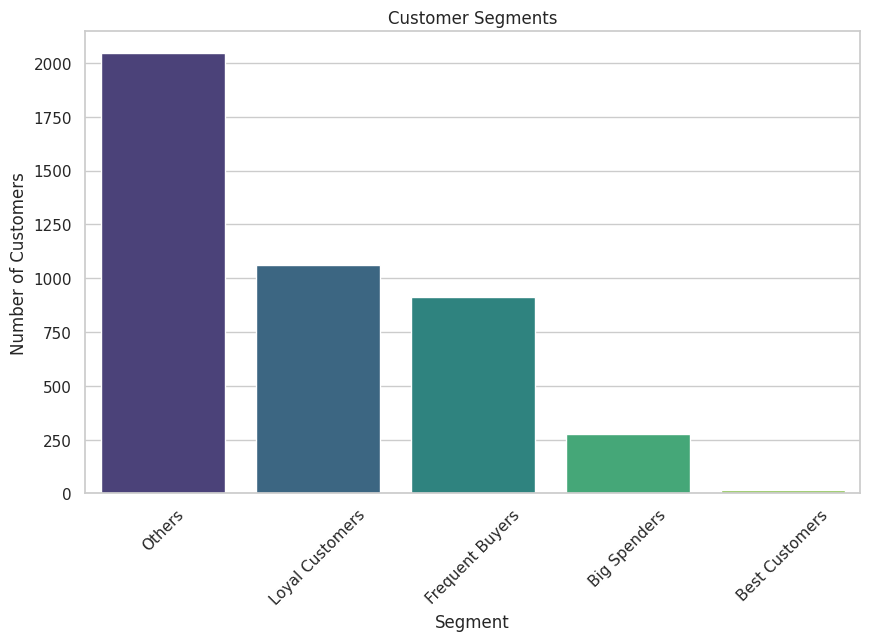

In [41]:
# Count of customers in each segment
segment_counts = rfm['Segment'].value_counts()

# Plot segment counts
plt.figure(figsize=(10,6))
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')
plt.title('Customer Segments')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()


In [42]:
# Calculate RFM score by combining the individual scores
rfm['RFM_Score'] = rfm['RecencyScore'] + rfm['FrequencyScore'] + rfm['MonetaryScore']

# Define segments based on RFM score
def segment_customer(df):
    if df['RFM_Score'] >= 9:
        return 'Champions'
    elif df['RFM_Score'] >= 6:
        return 'Potential Loyalists'
    elif df['RFM_Score'] >= 5:
        return 'At Risk Customers'
    else:
        return 'Lost'

# Apply segmentation
rfm['Segment'] = rfm.apply(segment_customer, axis=1)


<ipython-input-43-9a0d690191f0>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')


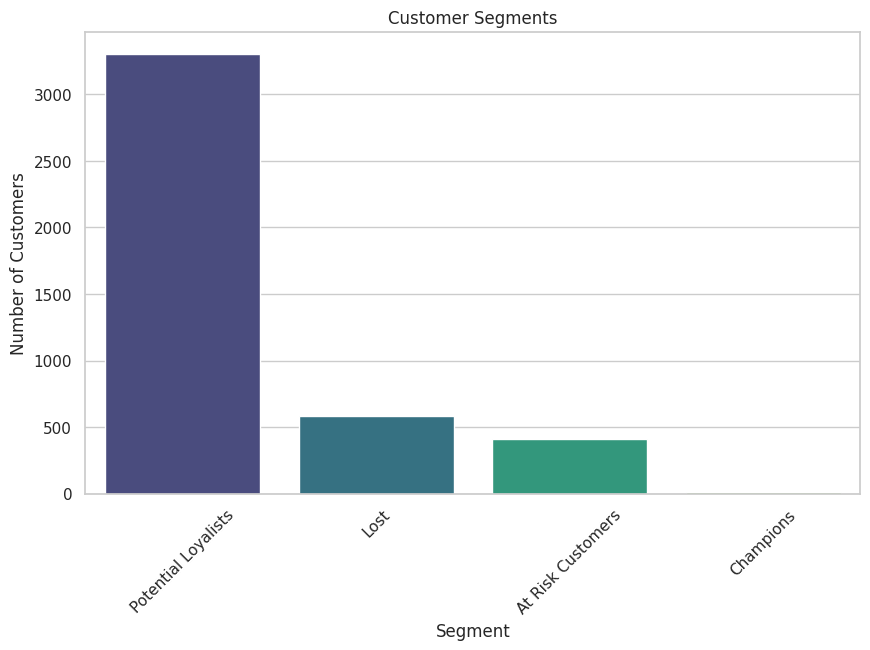

In [43]:
# Count of customers in each segment
segment_counts = rfm['Segment'].value_counts()

# Plot segment counts
plt.figure(figsize=(10,6))
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')
plt.title('Customer Segments')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()


In [44]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [45]:
# Set reference date (e.g., one day after the last transaction date)
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Calculate RFM metrics
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'Invoice': 'nunique',  # Frequency
    'TotalSales': 'sum'  # Monetary
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']


In [46]:
# Log transformation
rfm_log = np.log1p(rfm)

# Standardization
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)


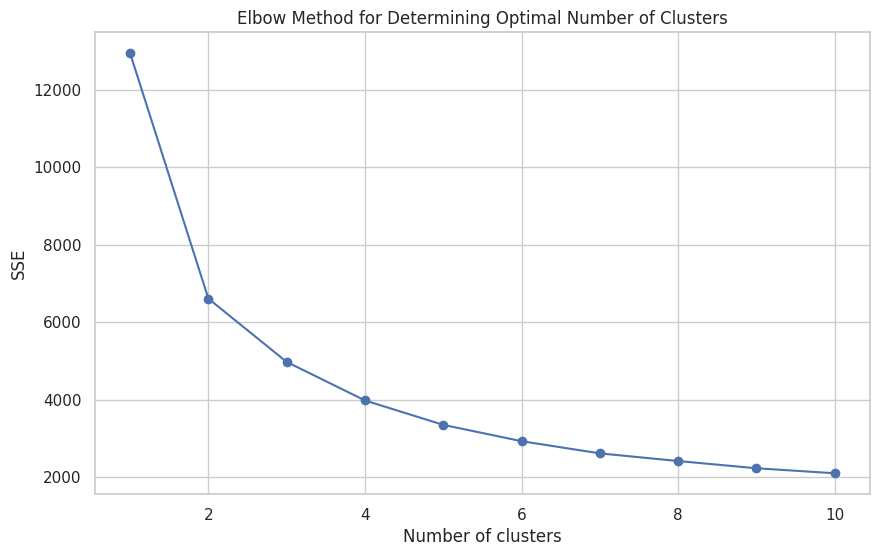

In [47]:
# Elbow method to determine optimal number of clusters
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse[k] = kmeans.inertia_

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.title("Elbow Method for Determining Optimal Number of Clusters")
plt.show()


In [48]:
# Apply K-Means with the optimal number of clusters
optimal_clusters = 4  # Update based on the elbow plot
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


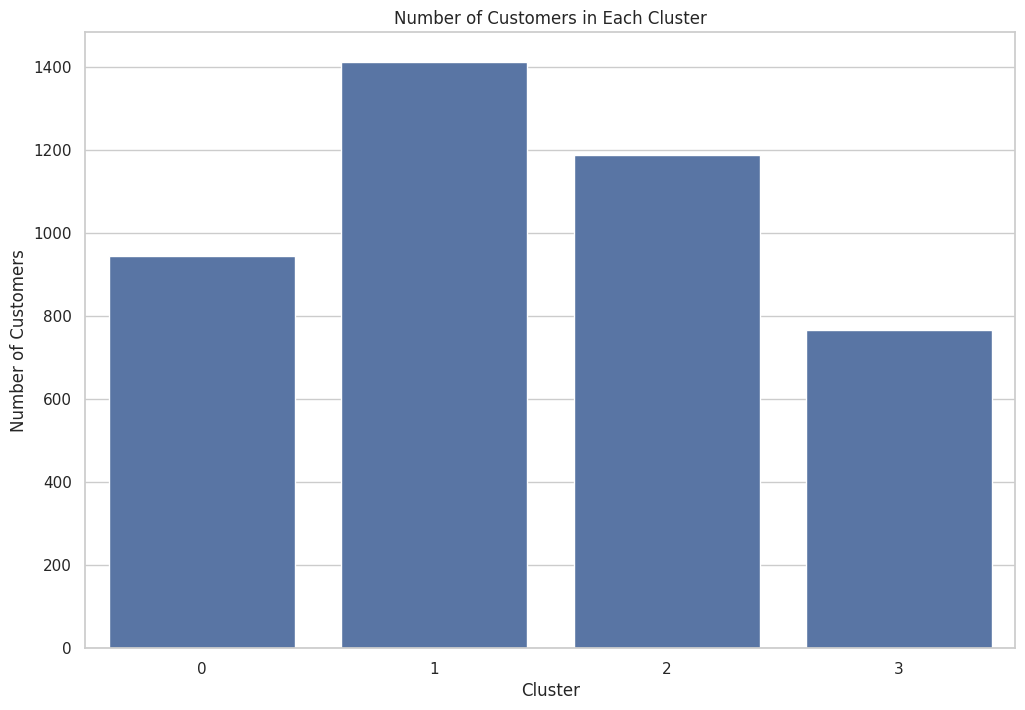

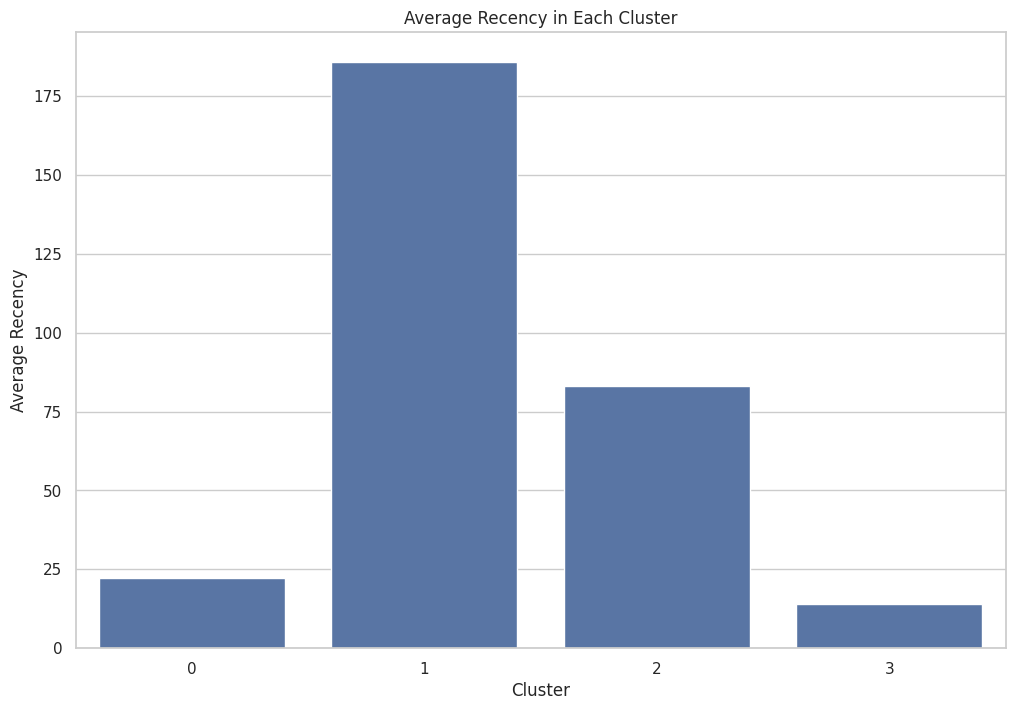

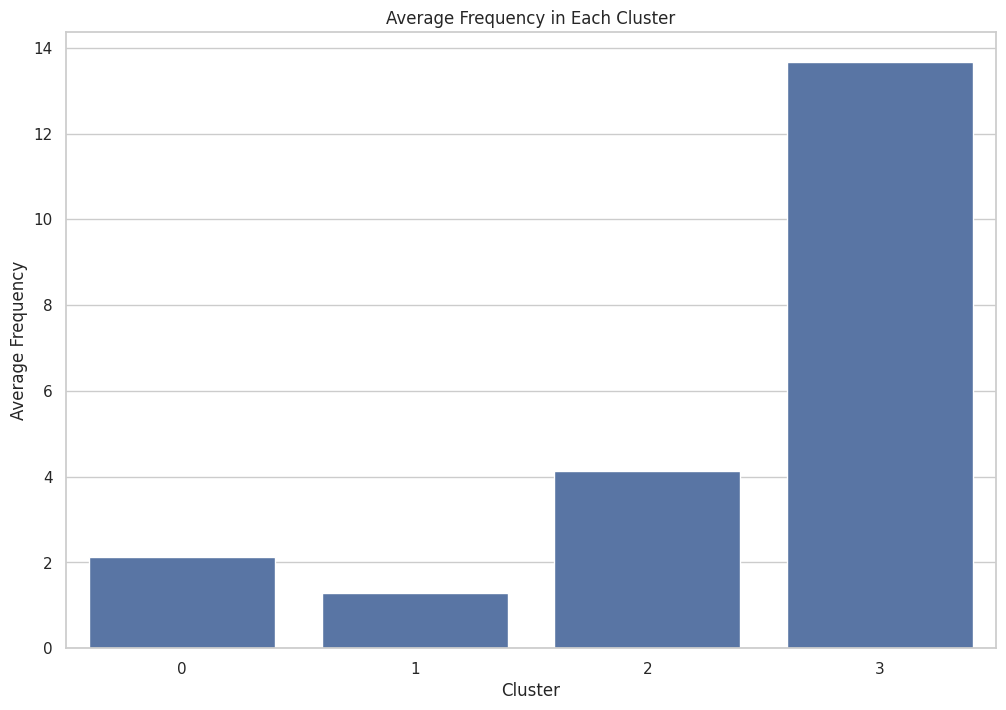

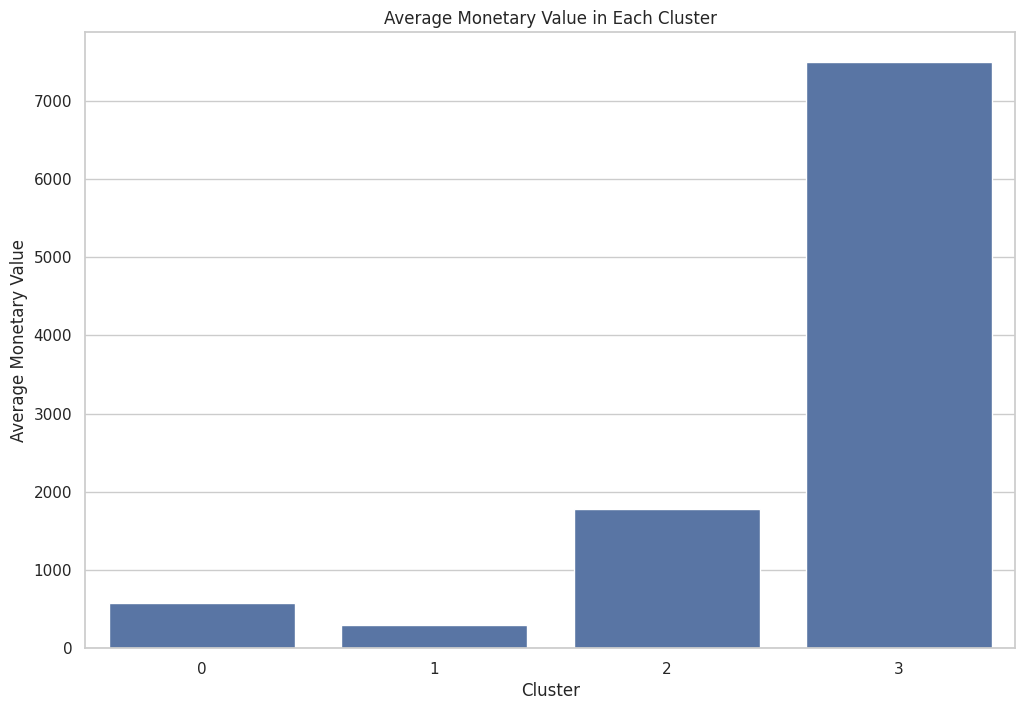

In [49]:
# Add cluster labels to the original RFM data
rfm['Cluster'] = kmeans.labels_

# Calculate average RFM values and size for each cluster
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Cluster': 'count'
}).rename(columns={'Cluster': 'Count'}).reset_index()

# Plot the cluster summary
plt.figure(figsize=(12, 8))
sns.barplot(x='Cluster', y='Count', data=cluster_summary)
plt.title('Number of Customers in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()

# Plot RFM values for each cluster
plt.figure(figsize=(12, 8))
sns.barplot(x='Cluster', y='Recency', data=cluster_summary)
plt.title('Average Recency in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Recency')
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x='Cluster', y='Frequency', data=cluster_summary)
plt.title('Average Frequency in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Frequency')
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x='Cluster', y='Monetary', data=cluster_summary)
plt.title('Average Monetary Value in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Monetary Value')
plt.show()


In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



<ipython-input-51-e88fa7a3f095>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Recency', data=rfm, ax=axes[0], palette="Set2")
<ipython-input-51-e88fa7a3f095>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Frequency', data=rfm, ax=axes[1], palette="Set2")
<ipython-input-51-e88fa7a3f095>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Monetary', data=rfm, ax=axes[2], palette="Set2")


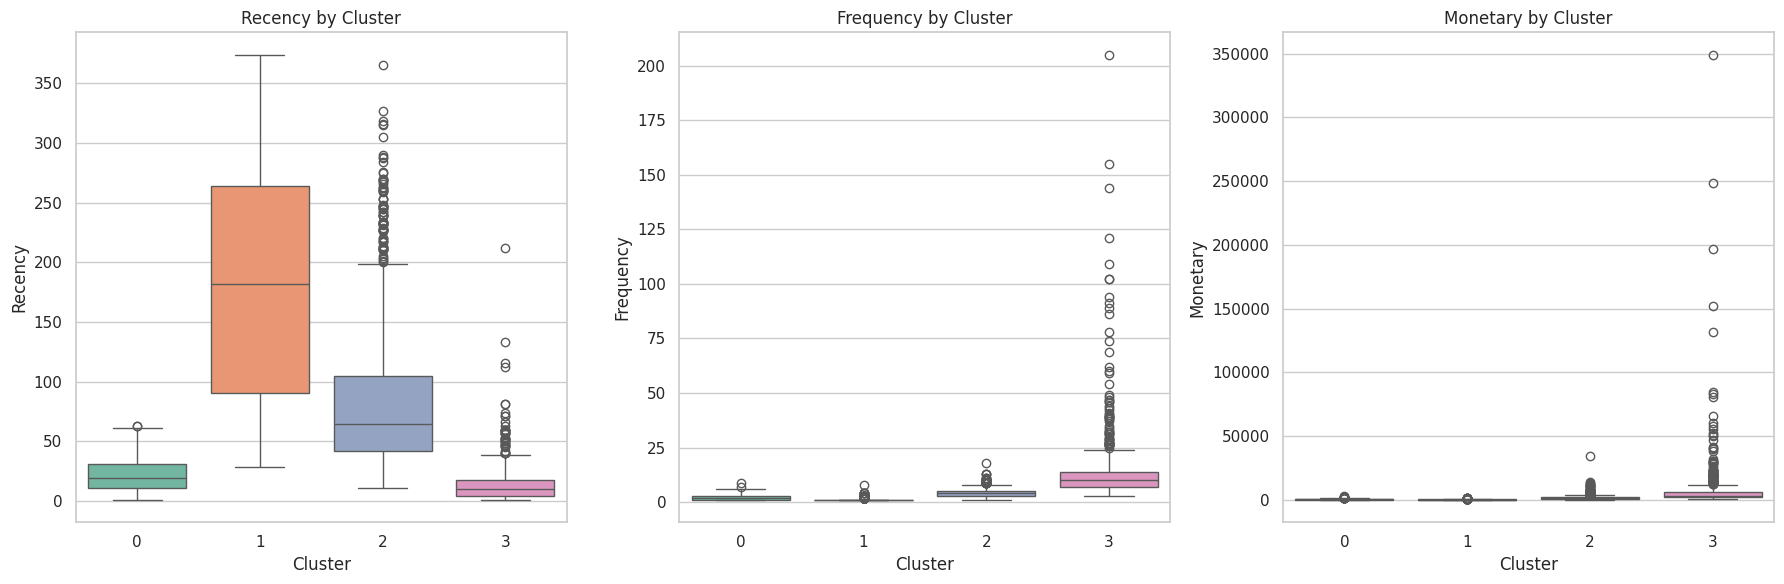

In [51]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Recency
sns.boxplot(x='Cluster', y='Recency', data=rfm, ax=axes[0], palette="Set2")
axes[0].set_title('Recency by Cluster')

# Plot Frequency
sns.boxplot(x='Cluster', y='Frequency', data=rfm, ax=axes[1], palette="Set2")
axes[1].set_title('Frequency by Cluster')

# Plot Monetary
sns.boxplot(x='Cluster', y='Monetary', data=rfm, ax=axes[2], palette="Set2")
axes[2].set_title('Monetary by Cluster')

# Display the plots
plt.tight_layout()
plt.show()



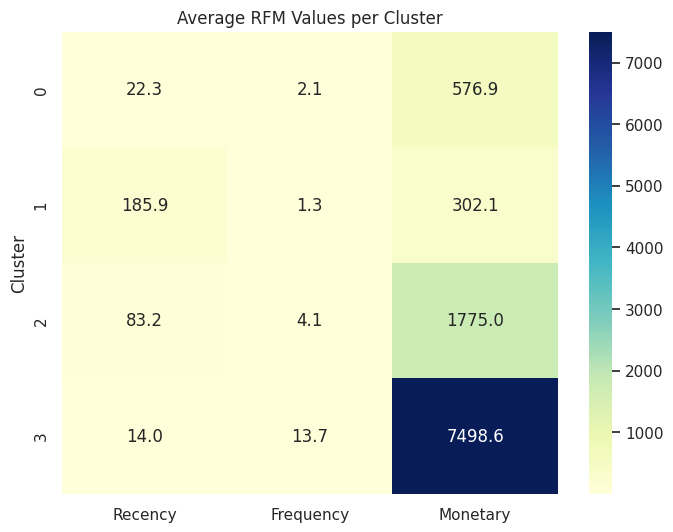

In [52]:
# Calculate the average RFM values for each cluster
cluster_avg = rfm.groupby('Cluster').mean().round(1)

# Reset index for better readability
cluster_avg = cluster_avg.reset_index()

# Set 'Cluster' as index
cluster_avg = cluster_avg.set_index('Cluster')

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cluster_avg, annot=True, cmap="YlGnBu", fmt='.1f')
plt.title('Average RFM Values per Cluster')
plt.show()


In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


In [54]:
!pip install google-cloud-bigquery pandas matplotlib seaborn


In [55]:
from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery
import pandas as pd

# Set your Google Cloud project ID
project_id = "retail-449009"



In [56]:
client = bigquery.Client(project=project_id)


In [58]:
query = """
SELECT *
FROM `retail-449009.retailsales.customer_clusters`
"""
df = client.query(query).to_dataframe()

# Display the DataFrame
print(df.head())


   Customer ID  Recency  Frequency  Monetary  Cluster
0      17180.0     5376          1     43.70        3
1      14854.0     5376          1     93.16        3
2      13979.0     5376          1     11.25        3
3      16108.0     5376          1      2.50        3
4      17092.0     5376          1    132.82        3


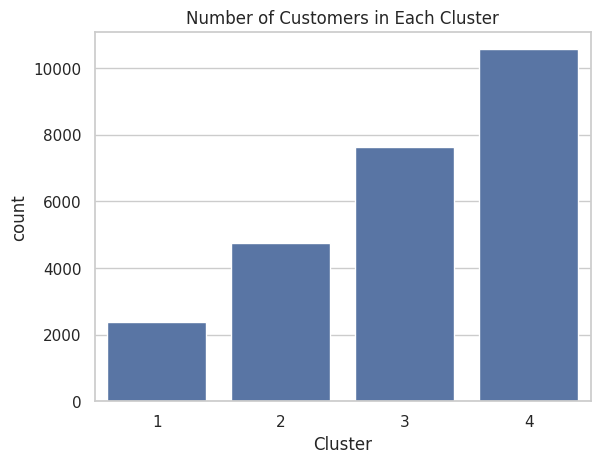

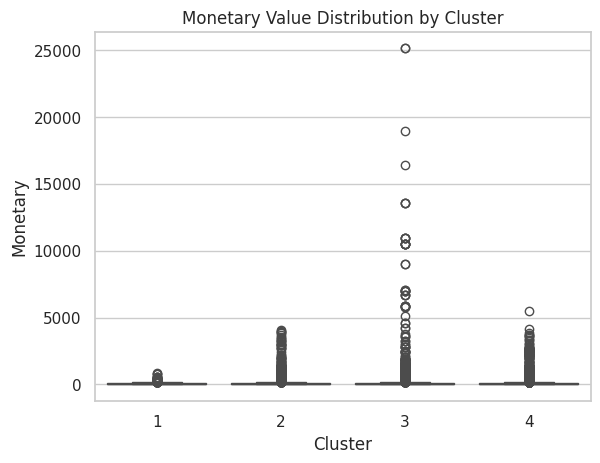

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

# Bar chart: Number of customers in each cluster
sns.countplot(x='Cluster', data=df)
plt.title('Number of Customers in Each Cluster')
plt.show()

# Box plot: Monetary value distribution by cluster
sns.boxplot(x='Cluster', y='Monetary', data=df)
plt.title('Monetary Value Distribution by Cluster')
plt.show()


In [63]:
cluster_summary = df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Customer ID': 'count'
}).rename(columns={'customer_id': 'num_customers'})
print(cluster_summary)


             Recency  Frequency    Monetary  Customer ID
Cluster                                                 
1        5524.443049        1.0   53.461018         2219
2         5452.69234   1.003165   96.131205         4417
3        5351.026588   1.025278  145.619366         6929
4        5218.720534   1.004828   85.706440         9922


In [65]:
# Example: Add business labels to clusters
cluster_labels = {
    1: 'High Value',
    2: 'At Risk',
    3: 'Low Value',
    4: 'Loyal Customers'
}
df['Cluster Label'] = df['Cluster'].map(cluster_labels)


In [67]:
X = rfm[['Recency', 'Frequency', 'Monetary']]  # Features
y = rfm['Cluster']  # Target

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Initialize and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97       189
           1       0.99      0.98      0.99       277
           2       0.97      0.96      0.96       243
           3       0.96      0.95      0.96       154

    accuracy                           0.97       863
   macro avg       0.97      0.97      0.97       863
weighted avg       0.97      0.97      0.97       863

Confusion Matrix:
 [[186   0   0   3]
 [  3 271   3   0]
 [  4   2 234   3]
 [  2   0   5 147]]


In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Build a neural network
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(len(rfm['Cluster'].unique()), activation='softmax')  # One output for each cluster
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5398 - loss: 1.1335 - val_accuracy: 0.6929 - val_loss: 0.7129
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7392 - loss: 0.6547 - val_accuracy: 0.8355 - val_loss: 0.4361
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8503 - loss: 0.4025 - val_accuracy: 0.8876 - val_loss: 0.2854
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9006 - loss: 0.2683 - val_accuracy: 0.9061 - val_loss: 0.2320
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9164 - loss: 0.2239 - val_accuracy: 0.9189 - val_loss: 0.2008
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9253 - loss: 0.2003 - val_accuracy: 0.9270 - val_loss: 0.1819
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9280 - loss: 0.1818 - val_accuracy: 0.9328 - val_loss: 0.1699
Epoch 8/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9483 - loss: 0.1529 - val_accuracy: 0.9455 - val_

In [70]:
# Example new customer data
new_customers = pd.DataFrame({
    'Recency': [10, 50],
    'Frequency': [5, 2],
    'Monetary': [300, 50]
})

# Scale the new data
new_customers_scaled = scaler.transform(new_customers)

# Predict clusters
predicted_clusters = rf_model.predict(new_customers_scaled)
print("Predicted Clusters:", predicted_clusters)


Predicted Clusters: [0 1]


In [71]:
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Cluster': 'count'
}).rename(columns={'Cluster': 'Num_Customers'})

print(cluster_summary)


            Recency  Frequency     Monetary  Num_Customers
Cluster                                                   
0         22.250794   2.121693   576.945207            945
1        185.938385   1.288244   302.142020           1412
2         83.191919   4.122054  1775.009363           1188
3         13.988266  13.679270  7498.636764            767


In [72]:
cluster_labels = {
    0: 'Loyal Customers',
    1: 'At-Risk Customers',
    2: 'Low-Value Customers',
    3: 'High-Value Customers'
}

# Add business labels to the DataFrame
rfm['Cluster_Label'] = rfm['Cluster'].map(cluster_labels)
print(rfm[['Cluster', 'Cluster_Label']].head())


             Cluster        Cluster_Label
Customer ID                              
12346.0            2  Low-Value Customers
12347.0            0      Loyal Customers
12348.0            1    At-Risk Customers
12349.0            2  Low-Value Customers
12351.0            0      Loyal Customers


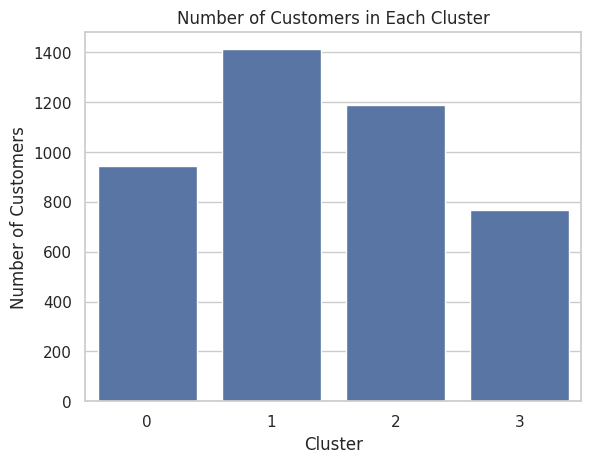

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Cluster', data=rfm)
plt.title('Number of Customers in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()


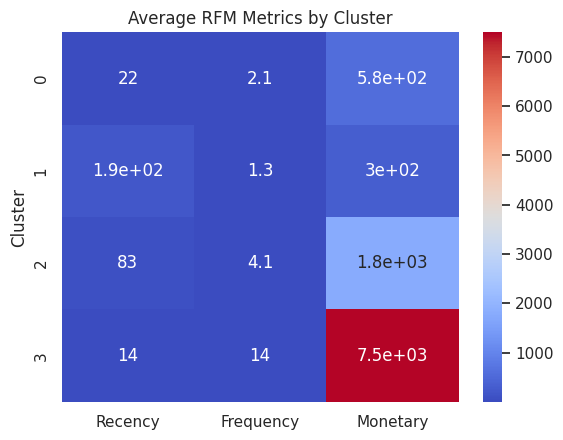

In [74]:
sns.heatmap(cluster_summary.drop(columns='Num_Customers'), annot=True, cmap='coolwarm')
plt.title('Average RFM Metrics by Cluster')
plt.show()


In [75]:
import plotly.express as px

fig = px.scatter_3d(df, x='Recency', y='Frequency', z='Monetary',
                     color='Cluster', opacity=0.8, size_max=10)
fig.update_layout(title="3D Customer Segmentation Scatter Plot")
fig.show()


In [85]:
import pandas as pd
import plotly.express as px

# Define customer segments based on cluster labels
segment_map = {
    0: "Occasional Buyers",
    1: "At-Risk Customers",
    2: "Loyal Customers",
    3: "High-Value Customers"
}

# Apply mapping and handle NaNs
df['Segment'] = df['Cluster'].map(segment_map)
df['Segment'] = df['Segment'].fillna("Unknown")  # Fix missing values

# Ensure monetary values are valid (remove negative values if necessary)
df['Monetary'] = df['Monetary'].abs()

# Generate Sunburst Chart
fig = px.sunburst(df, path=['Segment', 'Cluster'], values='Monetary',
                  color='Cluster', hover_data=['Recency', 'Frequency'])

fig.update_layout(title="Customer Segmentation - Sunburst Chart")
fig.show()


/usr/local/lib/python3.11/dist-packages/plotly/express/_core.py:1745: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

